# Desafio 3

Reutilización de notebooks para evaluar otro archivo de texto

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Dense, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import time
import matplotlib.pyplot as plt

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

# Carga de archivo de texto para analizar

In [ ]:
# Cada verso lo guardamos en una lista
text = []
filename = "./data/74376.txt"
with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
        text.append(line)

# Preprocesamiento

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

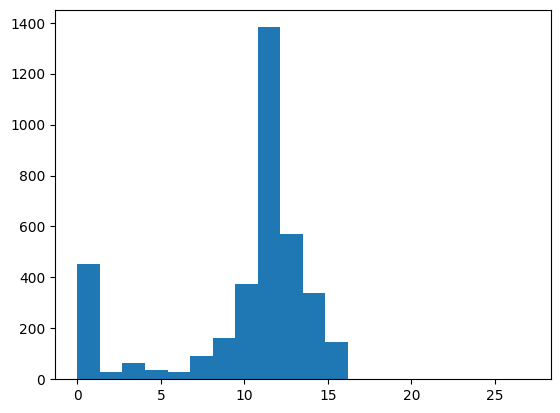

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)
plt.show()

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 13


# Tokenizar

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)
tokenized_sentences

[[2337, 52, 122, 371, 2, 1, 19, 3, 159],
 [],
 [14, 371, 6, 15, 1, 77, 2, 859, 1249, 5, 1, 254, 186, 3],
 [93, 64, 210, 2, 1, 110, 35, 61, 1015, 3, 10, 438, 61, 1250],
 [1625, 50, 53, 347, 9, 130, 9, 573, 12, 1251, 77, 9, 187, 1, 168],
 [2, 1, 52, 122, 275, 1016, 10, 14, 371, 12, 860],
 [35, 479, 122, 514, 49, 50, 20, 17, 574, 5, 1, 254, 186],
 [50, 65, 29, 4, 1017, 1, 400, 2, 1, 348, 103, 50, 20, 574],
 [255, 401, 14, 371],
 [],
 [2338, 1, 19, 3, 159],
 [],
 [2339, 1018, 1019],
 [],
 [2340, 1252, 2341, 745, 2342, 371, 2343],
 [],
 [243, 2344],
 [],
 [746, 2345, 402, 2346, 1, 144, 2, 402, 644, 1253],
 [],
 [2347,
  2348,
  2349,
  3,
  1,
  860,
  861,
  2350,
  2351,
  35,
  2352,
  479,
  2353,
  2354,
  14,
  1626,
  41,
  1254,
  24,
  862,
  2355,
  62,
  575,
  21,
  1,
  2356,
  349],
 [],
 [],
 [645, 2, 1, 52, 122, 371, 1, 19, 3, 159],
 [],
 [],
 [],
 [],
 [],
 [],
 [1, 19, 3, 159],
 [],
 [1, 144, 2, 402, 644],
 [402, 1255],
 [],
 [244],
 [],
 [1, 2357, 2358, 1256],
 [136, 1257

In [ ]:
max_context_size+1

14

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:
    # si la secuencia tiene más términos que el tamaño de contexto máximo,
    # armo varias sub-secuencias de tamaño máximo
    if len(sent) > (max_context_size+1):
        extra = len(sent)-(max_context_size+1) + 1
        for i in range(extra):
            tok_sent.append(sent[i:i+max_context_size+1])
        else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
            tok_sent.append(sent)

len(tok_sent)

398

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(5332, 14)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'to',
 5: 'in',
 6: 'is',
 7: 'a',
 8: 'that',
 9: 'it',
 10: 'with',
 11: 'as',
 12: 'or',
 13: 'be',
 14: 'this',
 15: 'for',
 16: 'which',
 17: 'not',
 18: 'child',
 19: 'school',
 20: 'are',
 21: 'by',
 22: 'work',
 23: 'life',
 24: 'from',
 25: 'all',
 26: 'but',
 27: 'we',
 28: 'his',
 29: 'have',
 30: 'its',
 31: 'social',
 32: 'an',
 33: 'so',
 34: 'on',
 35: 'at',
 36: 'there',
 37: 'has',
 38: 'they',
 39: 'he',
 40: 'one',
 41: 'was',
 42: 'children',
 43: 'these',
 44: 'more',
 45: 'out',
 46: 'upon',
 47: 'what',
 48: 'into',
 49: 'if',
 50: 'you',
 51: 'their',
 52: 'project',
 53: 'may',
 54: 'any',
 55: 'through',
 56: 'only',
 57: 'i',
 58: 'them',
 59: 'been',
 60: 'do',
 61: 'no',
 62: 'made',
 63: 'can',
 64: 'other',
 65: 'will',
 66: 'own',
 67: 'education',
 68: 'some',
 69: 'our',
 70: 'when',
 71: 'must',
 72: 'such',
 73: 'conditions',
 74: 'were',
 75: 'gutenberg™',
 76: '1',
 77: 'use',
 78: 'up',
 79: 'than',
 80: 'betwee

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

4504

# Definición del modelo

Para el modelo de prueba se diseño de la siguiente manera:

Una capa de embedding

Dos capas bidireccionales (LSTM) para que la red procese las secuencias en ambas

Tres capas densas

In [ ]:
model = Sequential()

# Embedding
model.add(Embedding(input_dim=vocab_size + 1, output_dim=5, input_shape=(max_context_size,)))

# LSTM Bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64))) # La última capa LSTM no lleva return_sequences

# Agregar más capas densas
model.add(Dense(64, activation='relu'))  # Aumentar neuronas
model.add(Dense(32, activation='relu'))  # Otra capa densa

# Predicción de clasificación con softmax
model.add(Dense(vocab_size + 1, activation='softmax'))

# Compilación del modelo
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

# Resumen del modelo
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 5)          │        22,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 13, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4505)           │       148,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,182 (1.21 MB)

 Trainable params: 316,182 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PplCallback(keras.callbacks.Callback):
    ''''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
        # El callback lo inicializamos con secuencias de validación sobre las cuales
        # mediremos la perplejidad
        self.val_data = val_data

        self.target = []
        self.padded = []

        count = 0
        self.info = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:
            len_seq = len(seq)
            # armamos todas las subsecuencias
            subseq = [seq[:i] for i in range(len_seq)]
            self.target.extend([seq[i] for i in range(len_seq)])
            self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

            self.info.append((count,count+len_seq))
            count += len_seq

        self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):
        scores = []
        predictions = self.model.predict(self.padded, verbose=0)

        for start, end in self.info:
            probs = [predictions[idx_seq, idx_vocab] + epsilon for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]
            if any(prob <= 0 for prob in probs):  # Verifica si hay probabilidades <= 0
                print("Warning: Found probability <= 0, may cause NaN in perplexity.")

        scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

        print(f'\n mean perplexity: {np.mean(scores)} \n')

 #   def on_epoch_end(self, epoch, logs=None):

 #       # en `scores` iremos guardando la perplejidad de cada secuencia
 #       scores = []

 #       predictions = self.model.predict(self.padded,verbose=0)

 #       # para cada secuencia de validación
 #       for start,end in self.info:

 #         # en `probs` iremos guardando las probabilidades de los términos target
 #         probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

 #         # calculamos la perplejidad por medio de logaritmos
 #         scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

 #       # promediamos todos los scores e imprimimos el valor promedio
 #       print(f'\n mean perplexity: {np.mean(scores)} \n')



In [ ]:
epsilon = 1e-10
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=75, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/75
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.9178
 mean perplexity: 1279.896460985434 

167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 6.9076
Epoch 2/75
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.3153
 mean perplexity: 2226.6052525217738 

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 5.3150
Epoch 3/75
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2575
 mean perplexity: 1776.604399945906 

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 5.2572
Epoch 4/75
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1375
 mean perplexity: 2327.0465228435655 

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 5.1370
Epoch 5/75
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9662
 mean perplexity: 5582.212233026264 

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.9663
Epoch 6/75
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7356
 mean perplexity: 10567.495166447052 

167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 4.7357
Epoch 7/75
166/167

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 61.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 64.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have ur

In [ ]:
import gradio as gr

In [ ]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://37a6853eb2b6bade8e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):

    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
        # Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
        # Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

        # Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='It is easy to'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'It is easy to look at'

El modelo está performando bien. Está creando una palabra con todo sentido. Y esta aprendiendo de la data con la que alimentamos el modelo

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):
    # colectar todas las probabilidades para la siguiente búsqueda
    pred_large = []

    for idx,pp in enumerate(pred):
        pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

    pred_large = np.array(pred_large)

    # criterio de selección
    # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

    # traducir a índices de token en el vocabulario
    new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

    # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):
        preds = []

        for hist in history_tokens:

            # actualizar secuencia de tokens
            input_update = np.array([hist[i+1:]]).copy()

            # predicción
            y_hat = np.squeeze(model.predict(input_update))

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

        return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=25,num_words=6,input="when i find myself in times")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
# veamos las salidas
for i in range(len(salidas)):
    print(decode(salidas[i]))


['when i find myself in times it the']
['when i find myself in times is as']
['when i find myself in times is to']
['when i find myself in times that away']
['when i find myself in times is so']
['when i find myself in times that the']
['when i find myself in times is a']
['when i find myself in times is a']
['when i find myself in times is we']
['when i find myself in times that the']
['when i find myself in times is to']
['when i find myself in times is that']
['when i find myself in times is to']
['when i find myself in times is true']
['when i find myself in times is we']
['when i find myself in times as it']
['when i find myself in times is we']
['when i find myself in times is to']
['when i find myself in times is “i']
['when i find myself in times that the']
['when i find myself in times that the']
['when i find myself in times is by']
['when i find myself in times is a']
['when i find myself in times that that']
['when i find myself in times is that']


Se puede evidenciar las diversas variantes creadas por el algoritmo.